<a href="https://colab.research.google.com/github/mitran27/GenerativeNetworks/blob/main/DiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torch.nn import Module,Sequential,Conv2d,GroupNorm,SiLU,Identity,Linear,LayerNorm,MultiheadAttention,ConvTranspose2d,ModuleList,MSELoss
import torch

In [2]:
def convBlock(in_dim,out_dim):
  return Sequential(Conv2d(in_dim,out_dim,3,padding=1),GroupNorm(8,out_dim),SiLU())
def timeEmeddingMLP(dim):
  return Sequential(Linear(dim,dim*4),SiLU(),Linear(dim*4,dim))
def FCN(dim):
  return Sequential(Linear(dim,dim*4),SiLU(),Linear(dim*4,dim))



class ResnetLayer(Module):
  def __init__(self, in_dim, out_dim, time_dim=None):
    super().__init__()

    self.block1 = convBlock(in_dim, out_dim)
    self.block2 = convBlock(out_dim, out_dim)

    self.resBlock = convBlock(in_dim,out_dim)  if(in_dim!=out_dim) else Identity()
    self.timeLinear = Sequential(SiLU(), Linear(time_dim, out_dim)) if time_dim else None

  def forward(self,X,timeLatent=None):
    y = self.block1(X)
    if(self.timeLinear):
      y = y + self.timeLinear(timeLatent).unsqueeze(-1).unsqueeze(-1)
    y = self.block2(y)

    y = y + self.resBlock(X)

    return y

class SinusoidalEmbeddings(Module):
  def __init__(self, dim):

    super().__init__()

    self.dim = dim//2

  def forward(self,timestep):

    freqs = torch.pow(10000, -torch.arange(self.dim, dtype=torch.float32,device=timestep.device) / self.dim)
    x = timestep[:, None] * freqs[None]
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)






In [3]:
class UnetAttention(Module):
  def __init__(self, dim, heads):
    super().__init__()

    self.layerNorm1 = LayerNorm(dim)
    self.layerNorm2 = LayerNorm(dim)

    self.conv_in = Conv2d(dim, dim ,kernel_size=1, padding=0)
    self.conv_out = Conv2d(dim, dim ,kernel_size=1, padding=0)

    self.qkv_linear = Linear(dim,dim*3)
    self.MHA = MultiheadAttention(dim , heads)
    self.fcn = FCN(dim)

  def attn(self,X):
    q,k,v = self.qkv_linear(X).chunk(3,dim=-1)
    return self.MHA(q,k,v)[0]
  def forward(self,X):

    y = self.conv_in(X)

    # convert image format to sequence format

    b,c,h,w = y.shape

    y = y.view((b, c, h * w))
    y_r = y.transpose(-1,-2)

    y = self.layerNorm1(y_r)
    y = self.attn(y)

    y_r = y + y_r

    y = self.layerNorm2(y_r)
    y = self.fcn(y)

    y = y + y_r

    y  = y.transpose(-1,-2)
    y = y.view((b, c, h , w))

    y = self.conv_out(y)

    # transformer under unet have property to add the input at end

    return y + X
class SamplingBlock(Module):
  def __init__(self,indim, outdim, timedim, no_heads):
    super().__init__()

    self.res_block1 = ResnetLayer(indim, outdim, timedim)
    self.res_block2 = ResnetLayer(outdim, outdim, timedim)
    self.attn_block = UnetAttention(outdim,no_heads)
  def forward(self, X, time):
    y = self.res_block1(X,time)
    y = self.res_block2(y,time)
    y = self.attn_block(y)

    return y

In [4]:
class downSamplingBlock(SamplingBlock):
  def __init__(self,indim, outdim, timedim, no_heads, down_sample=False):
    super().__init__(indim, outdim, timedim, no_heads)
    self.down_sample =Conv2d(outdim, outdim, kernel_size=4, stride=2, padding=1) if down_sample else Identity()



  def forward(self,X,time):
    latent = super().forward(X,time)
    y = self.down_sample(latent)
    return y, latent


class upSamplingBlock(SamplingBlock):
  def __init__(self,indim, outdim, timedim, no_heads, up_sample=False):
    super().__init__(indim, outdim, timedim, no_heads)
    self.up_sample = ConvTranspose2d(indim, indim//2, kernel_size=4, stride=2, padding=1) if up_sample else Identity()


  def forward(self,X, latent,time):
    y = self.up_sample(X)
    y = torch.cat([y, latent],dim=1)
    y = super().forward(y,time)

    return y

In [5]:

def bottleNeckBlock(dim, heads):
  return Sequential(
      ResnetLayer(dim, dim, None),
      UnetAttention(dim,heads),
      ResnetLayer(dim, dim, None),
  )

In [6]:
class UNET(Module):
  def __init__(self, config):

    super().__init__()

    self.timeEmbedding  = Sequential(SinusoidalEmbeddings(config.base_dim),timeEmeddingMLP(config.base_dim))

    self.init_conv =Conv2d(config.channels, config.base_dim, 7, padding=3)

    self.encoder = ModuleList([ downSamplingBlock(indim, outdim,config.base_dim, config.heads,downsample) for (indim, outdim, downsample) in config.downsamplingDimensions ])
    self.bottleNeck = bottleNeckBlock(config.downsamplingDimensionsLast,config.heads)
    self.decoder = ModuleList([ upSamplingBlock(indim, outdim,config.base_dim, config.heads,upsample) for (indim, outdim, upsample) in config.upsamplingDimensions ])

    outdim = config.upsamplingDimensionsLast
    self.finalConv = Sequential(
        convBlock(outdim, outdim),
        Conv2d(outdim,config.channels,3,padding=1)
    )

  def forward(self,X, time_step):

    time_Embedding = self.timeEmbedding(time_step)
    skip_connections = []

    y = self.init_conv(X)
    for layer in self.encoder:
      y, latent = layer(y,time_Embedding)
      skip_connections.append(latent)

    y = self.bottleNeck(y)

    for layer in self.decoder:

      y = layer(y, skip_connections.pop(),time_Embedding)
      #print(y.shape)

    y = self.finalConv(y)

    return y






In [20]:
class DiffusionModelConfig():
  base_dim = 64

  downsamplingDimensions = [(64,128,True),(128,256,True),(256,512,False),(512,512,False)]
  downsamplingDimensionsLast = 512
  upsamplingDimensions = [(1024,512,False),(1024,512,False),(512,256,True),(256,128,True)]
  upsamplingDimensionsLast = 128

  channels = 3
  heads = 4


class BetaArgs:
  beta_start = 1e-4
  beta_end = 0.02
  steps = 1000




In [21]:
model = UNET(DiffusionModelConfig)
X = torch.randn(1,3,32,32)
print(X.shape)
y = model(X,torch.tensor([100]))
print(y.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


Dataset

In [22]:
!pip install  matplotlib tqdm

In [23]:
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

def get_dataset(dataset_name, batch_size, size):
    trans = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(size,interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
            transforms.RandomHorizontalFlip(),
            transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
        ]
    )

    if dataset_name.upper() == "MNIST":
        dataset = datasets.MNIST(root="data", train=True, download=True, transform=trans)
    elif dataset_name == "Cifar-10":
        dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=trans)
    elif dataset_name == "Cifar-100":
        dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=trans)
    elif dataset_name == "Flowers":
        dataset = datasets.ImageFolder(root="/kaggle/input/flowers-recognition/flowers", transform=trans)


    dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True)

    return dataloader

def inverse_transform(tensors):
    """Convert tensors from [-1., 1.] to [0., 255.]"""
    if(tensors.shape[0]==3): tensors = tensors.permute(1, 2, 0)
    return ((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0

In [24]:
dataset = get_dataset("Cifar-100",128,(64,64))

Files already downloaded and verified


torch.Size([3, 521, 1041]) torch.Size([128, 3, 64, 64])


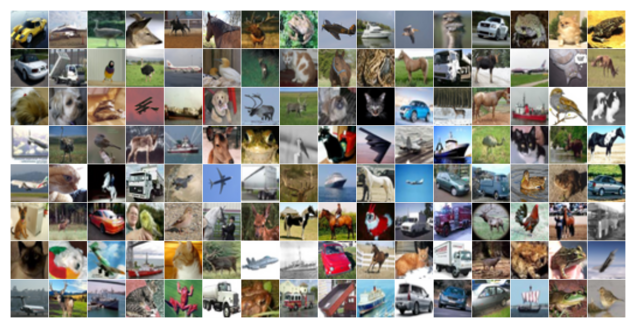

In [25]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4), facecolor='white')
sampleImage = None
for b_image, _ in dataset:
    sampleImage = b_image[0]
    b_image = inverse_transform(b_image)

    grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1)
    print(grid_img.shape,b_image.shape)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    break

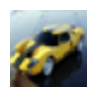

In [26]:
plt.figure(figsize=(1, 1), facecolor='white')
plt.axis("off")
plt.imshow(inverse_transform(sampleImage).numpy()/255)

In [27]:

class DDPMSampler(Module):
  def __init__(self, beta_args,device=torch.device("cpu")):
    super().__init__()

    self.betas = torch.linspace(beta_args.beta_start,beta_args.beta_end,beta_args.steps).to(device)
    self.alphas = 1 - self.betas
    self.nos = beta_args.steps
    self.alphas_cum = torch.cumprod(self.alphas, dim=0)
    self.length = beta_args.steps
  def __len__(self):return self.length

  def unsqueeze(self,x):
    return x.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

  def sample_Q(self, X0, time_step):  # Forward Diffusion

    noise = torch.randn_like(X0)
    sqrt_alpha_prod = self.unsqueeze(torch.sqrt(self.alphas_cum[time_step]))
    one_minus_sqrt_alpha_prod = self.unsqueeze(torch.sqrt(1-self.alphas_cum[time_step]))

    return X0 * sqrt_alpha_prod + noise * one_minus_sqrt_alpha_prod , noise

  def sample_P(self,diffusedImage, predNoise , time_step): # Reverse Diffusion

    # remove noise from the diffused image

    sqrt_alpha = torch.sqrt(self.alphas[time_step])
    beta = self.betas[time_step]
    one_minus_sqrt_alpha_prod = torch.sqrt(1-self.alphas_cum[time_step])


    z = torch.randn_like(diffusedImage) if time_step > 1 else torch.zeros_like(diffusedImage) # introduce some randomeness
    return (1/sqrt_alpha) * (diffusedImage -  (beta/one_minus_sqrt_alpha_prod) * predNoise )  + torch.sqrt(beta) * z






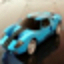

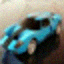

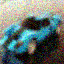

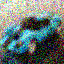

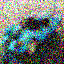

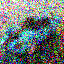

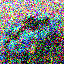

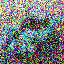

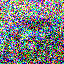

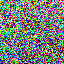

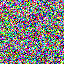

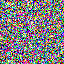

In [28]:
from google.colab.patches import cv2_imshow
sampler = DDPMSampler(BetaArgs)
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]
for ts in specific_timesteps:
  diffusedImage,_ = sampler.sample_Q(sampleImage,torch.tensor(ts))
  cv2_imshow(inverse_transform(diffusedImage).numpy())





In [29]:
from tqdm import tqdm
class Pipeline():
  def __init__(self, sampler, model, device):

    self.model = model
    self.sampler = sampler
    self.device = device = torch.device(device)
    self.sampler = self.sampler.to(self.device)
    self.model = self.model.to(self.device)
  def compile(self, learning_rate):
    self.lossFn = MSELoss();
    self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
  def train_one_epoch(self,data_loader):

    self.model.train()
    lossList = []

    with tqdm(total=len(data_loader)) as tq:

        for X0,_ in data_loader:
          tq.update(1)

          X0 =X0.to(self.device)

          timeStampBatch = torch.randint(low=1, high=len(self.sampler), size=(X0.shape[0],)).to(self.device)
          noiseImg, Noise = self.sampler.sample_Q(X0,timeStampBatch)

          noise_pred = self.model(noiseImg, timeStampBatch)
          loss = self.lossFn(Noise,noise_pred)

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

          loss_value = loss.detach().item()
          lossList.append(loss_value)
          tq.set_postfix_str(s=f"Loss: {loss_value:.4f}")

    print("Loss for the epoch ",sum(lossList)/len(lossList))

  def train(self, data_loader, epochs):
    for e in range(epochs):
      print("running epoch :",e)
      self.train_one_epoch(data_loader)






In [30]:
dataset = get_dataset("Cifar-100",128,(32,32))
diffusionmodel = UNET(DiffusionModelConfig)
sampler = DDPMSampler(BetaArgs,torch.device("cuda"))

Files already downloaded and verified


In [31]:


pipeline = Pipeline(sampler, diffusionmodel, "cuda")
pipeline.compile( 2e-4)


In [ ]:

pipeline.train(dataset,800)


running epoch : 0


100%|██████████| 391/391 [13:44<00:00,  2.11s/it, Loss: 0.0622]


Loss for the epoch  0.1015060584029883
running epoch : 1


100%|██████████| 391/391 [14:12<00:00,  2.18s/it, Loss: 0.0341]


Loss for the epoch  0.04540317692338963
running epoch : 2


100%|██████████| 391/391 [14:12<00:00,  2.18s/it, Loss: 0.0345]


Loss for the epoch  0.04149257090619153
running epoch : 3


100%|██████████| 391/391 [14:12<00:00,  2.18s/it, Loss: 0.0507]


Loss for the epoch  0.038547871624836534
running epoch : 4


100%|██████████| 391/391 [14:13<00:00,  2.18s/it, Loss: 0.0350]


Loss for the epoch  0.03687300979900543
running epoch : 5


100%|██████████| 391/391 [14:14<00:00,  2.19s/it, Loss: 0.0432]


Loss for the epoch  0.035428192275945486
running epoch : 6


 83%|████████▎ | 326/391 [11:51<02:22,  2.20s/it, Loss: 0.0329]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
checkpoint_dict = { "model": pipeline.model.state_dict()}
torch.save(checkpoint_dict, "/content/sample_data/ckpt.pt")
del checkpoint_dict


In [ ]:
diffusionmodel = UNET(DiffusionModelConfig)

diffusionmodel.load_state_dict(torch.load("/content/drive/MyDrive/ckpt.pt", map_location='cpu')['model'])


In [ ]:
def testDDPM(num_images,model,sampler,device):

  model = model.to(device)
  sampler = sampler.to(device)

  Xt = torch.randn( (num_images, 3,32,32), device=device)
  model.eval()

  for time_step in tqdm(iterable=reversed(range(1, 1000)),
                          total=1000-1, dynamic_ncols=False,
                          desc="Sampling :: ", position=0):

    ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step
    with torch.no_grad():
      eps_xt = model(Xt,ts)

      Xt_1 = sampler.sample_P(Xt, eps_xt ,ts)
      Xt = Xt_1
      if(time_step%50==0 or time_step==1):
        cv2_imshow(inverse_transform(Xt_1[0].cpu()).detach().numpy())


In [ ]:
sampler = DDPMSampler(BetaArgs,torch.device("cuda"))
testDDPM(1,diffusionmodel,sampler,torch.device("cuda"))